<a href="https://colab.research.google.com/github/anogassis/aisf-project/blob/eda-notebooks/notebooks/plot-runs-with-biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%pip install devinterp scipy pyyaml pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 22.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2

In [12]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from typing import Iterable, Optional, Callable, Dict, List, Any
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from torch.utils.data import DataLoader
from tqdm import tqdm
import itertools
from torch.utils.data import TensorDataset
from torch.nn import functional as F
from devinterp.slt import estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD

from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Load the uploaded pickle file
file_path = '/content/drive/MyDrive/Projects/AI Safety/AI Safety Fundamentals/runs/models/20240515_logs_lossall_runs.pkl'
with open(file_path, 'rb') as file:
    results = pickle.load(file)

In [14]:
print(len(results))

160


In [15]:
def generate_2d_kgon_vertices(k, rot=0., pad_to=None, force_length=0.9):
    """Set the weights of a 2D k-gon to be the vertices of a regular k-gon."""
    # Angles for the vertices
    theta = np.linspace(0, 2*np.pi, k, endpoint=False) + rot

    # Generate the vertices
    x = np.cos(theta)
    y = np.sin(theta)
    result = np.vstack((x, y))

    if pad_to is not None and k < pad_to:
        num_pad = pad_to - k
        result = np.hstack([result, np.zeros((2, num_pad))])

    return (result * force_length)

def generate_init_param(m, n, init_kgon, prior_std=1., no_bias=True, init_zerobias=True, seed=0, force_negb=False, noise=0.01):
    np.random.seed(seed)

    if init_kgon is None or m != 2:
        init_W = np.random.normal(size=(m, n)) * prior_std
    else:
        assert init_kgon <= n
        rand_angle = np.random.uniform(0, 2 * np.pi, size=(1,))
        noise = np.random.normal(size=(m, n)) * noise
        init_W = generate_2d_kgon_vertices(init_kgon, rot=rand_angle, pad_to=n) + noise

    if no_bias:
        param = {"W": init_W}
    else:
        init_b = np.random.normal(size=(n, 1)) * prior_std
        if force_negb:
            init_b = -np.abs(init_b)
        if init_zerobias:
            init_b = init_b * 0
        param = {
            "W": init_W,
            "b": init_b
        }
    return param

def plot_polygon(
    W: torch.Tensor,
    b=None,
    ax=None,
    ax_bias=None,
    ax_wnorm=None,
    hull_alpha=0.3,
    dW=None,
    dW_scale=0.3,
    orderb=True,
    color="b",
):
    """Credits: Edmund Lau"""
    if ax is None:
        if W.shape[0] == 2:
            fig, ax = plt.subplots(1, 1)
        elif W.shape[0] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")

    if W.shape[0] == 2:  # 2D case
        # Compute the norms of the columns
        norms = np.linalg.norm(W, axis=0)

        # Normalize a copy of the vectors for angle calculations
        W_normalized = W / norms

        # Compute angles from the x-axis for each vector
        angles = np.arctan2(W_normalized[1, :], W_normalized[0, :])

        # Sort the columns of W by angles
        order = np.argsort(angles)
        W_sorted = W[:, order]

        # Plot the origin
        ax.scatter(0, 0, color="red")

        # Plot the vectors
        for i in range(W_sorted.shape[1]):
            ax.quiver(
                0,
                0,
                W_sorted[0, i],
                W_sorted[1, i],
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.003,
            )
        if dW is not None:
            dW = -dW_scale * dW / np.max(np.linalg.norm(dW, axis=0))
            for col in range(W.shape[1]):
                ax.quiver(
                    W[0, col],
                    W[1, col],
                    dW[0, col],
                    dW[1, col],
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    color="r",
                    width=0.005,
                )

        # Connect the vectors to form a polygon
        polygon = np.column_stack((W_sorted, W_sorted[:, 0]))
        ax.plot(polygon[0, :], polygon[1, :], alpha=0.5)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        vs = list(hull.vertices) + [hull.vertices[0]]
        ax.plot(W[0, vs], W[1, vs], "r--", alpha=hull_alpha)

        # Set the aspect ratio of the plot to equal to ensure that angles are displayed correctly
        ax.set_aspect("equal", adjustable="box")

    elif W.shape[0] == 3:  # 3D case
        # Plot the origin
        ax.scatter([0], [0], [0], color="red")

        # Plot the vectors
        for i in range(W.shape[1]):
            ax.plot([0, W[0, i]], [0, W[1, i]], [0, W[2, i]], color)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(W[0, s], W[1, s], W[2, s], "r--", alpha=hull_alpha)
    else:
        raise ValueError("W must have either 2 or 3 rows")

    if b is not None and ax_bias is not None and W.shape[0]==2:

        b_plot = np.ravel(b)
        if orderb:
            b_plot = b_plot[order]
        bar_colors = ["r" if val < 0 else "g" for val in b_plot]
        yticks = np.array(range(1, len(b_plot) + 1))
        ax_bias.barh(
            yticks - 0.4,
            np.abs(b_plot),
            height=0.4,
            color=bar_colors,
            align="edge",
        )
        ax_bias.set_yticks(yticks)
        ax_bias.yaxis.tick_right()
        ax_bias.tick_params(axis="y", labelsize="x-small")
        ax_bias.tick_params(axis="x", labelsize="x-small")

    if ax_wnorm is not None and W.shape[0]==2:
        yticks = np.array(range(1, W.shape[1] + 1))
        wnorms = np.linalg.norm(W, axis=0)
        if orderb:
            wnorms = wnorms[order]
        ax_wnorm.barh(yticks, width=wnorms, height=0.4, color="black", alpha=0.9, align="edge")
    return ax


def plot_polygons(Ws, biases, axes=None,ax_biases=None):
    if axes is None:
        fig, axes = plt.subplots(1, len(Ws), figsize=(15, 4))
    if ax_biases is None:
        fig, ax_biases = plt.subplots(1, len(Ws), figsize=(15, 4))

    for ax, W,ax_b,b in zip(axes, Ws, ax_biases,biases):
        plot_polygon(W,b=b, ax=ax, ax_bias=ax_b,ax_wnorm=ax_b)


def plot_losses_and_polygons(steps, losses, highlights, Ws, biases,xscale="log", yscale="log",batch_size=None, run=None, version = None):
    fig = plt.figure(figsize=(15, 6))

    gs = fig.add_gridspec(3, len(Ws))
    ax_losses = fig.add_subplot(gs[2, :])
    ax_polygons = []
    ax_biases = []


    max_x, min_x = max([np.max(W[0]) for W in Ws]), min([np.min(W[0]) for W in Ws])
    max_y, min_y = max([np.max(W[1]) for W in Ws]), min([np.min(W[1]) for W in Ws])

    for i in range(len(Ws)):
        ax = fig.add_subplot(gs[0, i], adjustable='box')
        ax.set_aspect('equal')
        ax_polygons.append(ax)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y+0.5)
    for i in range(len(Ws)):
        ax = fig.add_subplot(gs[1, i], adjustable='box')
        ax_biases.append(ax)
        ax.set_xlim(0, 1.5)
        #ax.set_ylim(0, 1.5)



    ax_losses.plot(steps, losses)
    ax_losses.set_xlabel("Step")
    ax_losses.set_ylabel("Loss")
    ax_losses.set_xscale(xscale)
    ax_losses.set_yscale(yscale)

    for i, step in enumerate(highlights):
        ax_losses.axvline(step, color="gray", linestyle="--")

    plot_polygons(Ws,biases,ax_polygons, ax_biases=ax_biases)
    version_str = f"Version: {version}" if version is not None else ""
    batch_size_str = f"Batch size: {batch_size}" if batch_size is not None else ""
    run_str = f"Run: {run}" if run is not None else ""
    plt.suptitle("Loss and Weight snapshots, " + batch_size_str + " " + run_str+ " " + version_str)
    plt.tight_layout()

In [31]:
STEPS = results[0]['parameters']['log_ivl']

In [32]:
logs = results[0]['logs']

In [33]:
losses = [logs.loc[logs['step'] == s, 'loss'].values[0] for s in STEPS]

In [34]:
NUM_EPOCHS = 20000
PLOT_STEPS = [min(STEPS, key=lambda s: abs(s-i)) for i in [0, 200, 2000, 10000, NUM_EPOCHS - 1]]
PLOT_INDICES = [STEPS.index(s) for s in PLOT_STEPS]

In [53]:
Ws = [results[0]['weights'][i]['embedding.weight'] for i in PLOT_INDICES]
biases = [results[0]['weights'][i]['unembedding.bias'] for i in PLOT_INDICES]

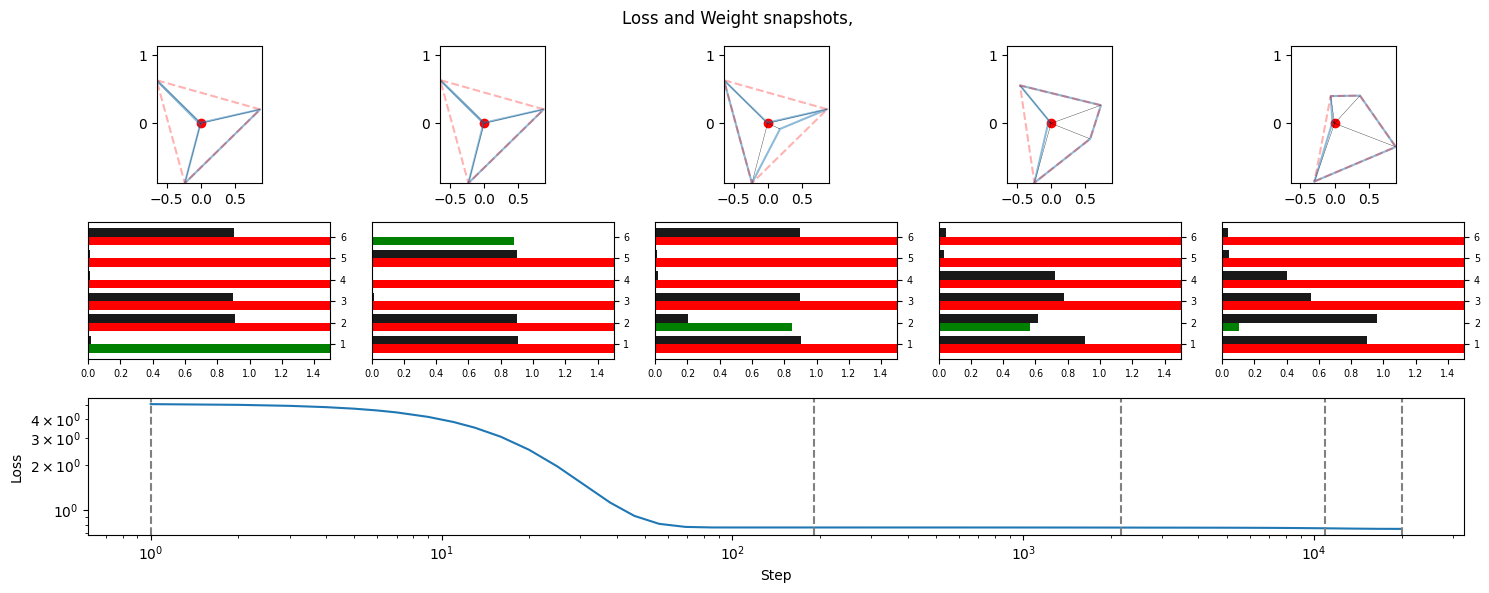

In [54]:
plot_losses_and_polygons(STEPS, losses, PLOT_STEPS, Ws, biases,xscale="log", yscale="log",batch_size=None, run=None, version = None)

In [ ]:
# ||Wi|| = black

## Plot all experiments

In [55]:
def plot_experiments(
    results: List[Dict[str, Any]],
    show:bool = True,
    save: bool = False,
    file_name: str = None
    ) -> None:
    """
    Plots the results of the experiments using plot_losses_and_polygons.

    Parameters
    ----------
    results : List[dict]
        A list of dictionaries, each containing the run_id, parameters used, logs, and weights.
    """
    for result in results:
        run_id = result['run_id']
        params = result['parameters']
        logs = result['logs']
        weights = result['weights']

        # Extract steps and losses from logs
        steps = list(logs['step'].values)
        losses = list(logs['loss'].values)

        # Generate highlight steps based on the number of epochs
        num_epochs = params.get('num_epochs', 100)
        num_observations = 50
        plot_steps = [min(steps, key=lambda s: abs(s-i)) for i in [0, 200, 2000, 10000, num_epochs - 1]]
        plot_indices = [steps.index(s) for s in plot_steps]

        # Extract weights at the highlight steps
        Ws = [weights[i]['embedding.weight'] for i in plot_indices]
        biases = [weights[i]['unembedding.bias'] for i in plot_indices]

        # Check for NaNs in W.T
        if np.isnan(Ws[-1].T).any():
            print(f"Skipping run {run_id} due to NaNs in W.T.")
            continue

        # Plot losses and polygons
        plt.figure()
        plot_losses_and_polygons(steps, losses, plot_steps, Ws, biases)

        # Title the plot based on parameters
        keys_in_title = ['run_id','m', 'n' ,'num_samples', 'batch_size', 'sparsity', 'lr']
        title = ', '.join(f'{key}: {value}' for key, value in params.items() if key in keys_in_title)
        plt.suptitle(f'Run ID: {run_id}\n {title}')
        plt.tight_layout()

        if show:
            plt.show()

        if save:
            plt.savefig(f'{file_name}_{run_id}.png')

        plt.close()

In [57]:
#plot_experiments(results, show=True, save=False, file_name='experiments')